In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:45037 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.44 GB


In [3]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2021, 2022],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [4]:
data = dict()

In [5]:
%%time

for year in config.years:
    config['year'] = year
    data[year] = load_checkpoint(config)

# checkpoint reloaded.

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
CPU times: user 36.5 ms, sys: 0 ns, total: 36.5 ms
Wall time: 43.7 ms


In [6]:
%%time

data['all'] = dd.concat(list(data.values()), interleave_partitions=False)


CPU times: user 28.8 ms, sys: 0 ns, total: 28.8 ms
Wall time: 28.6 ms


In [7]:

len(data['all'].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

61

In [8]:
%%time

get_ddf_shape(data['all'])

CPU times: user 1.08 s, sys: 276 ms, total: 1.36 s
Wall time: 7.65 s


(12531398, 23)

In [9]:
data['all']

,station_id,num_docks_available,num_bikes_available,status,timestamp,is_installed,is_renting,is_returning,is_charging_station,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,year,month,dayofweek,day,dayofyear,hour,capacity,ctx0,ctx1,ctx2,ctx3,ctx4
npartitions=60,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [10]:
%%time

nans = get_features_nans(data['all'])

zeros = get_features_zero(data['all'])

CPU times: user 4.5 s, sys: 724 ms, total: 5.22 s
Wall time: 28.9 s


In [11]:
nans

{'ctx0': 0.010437781961757181,
 'ctx1': 0.010437781961757181,
 'ctx2': 0.010437781961757181,
 'ctx3': 0.010437781961757181,
 'ctx4': 0.010437781961757181}

In [12]:
zeros

{'num_docks_available': 1.0915621704777072,
 'num_bikes_available': 6.703354246669047,
 'status': 95.62907506409101,
 'is_installed': 0.0027052049579783517,
 'is_renting': 0.06155737771635695,
 'is_returning': 0.06148555811570266,
 'is_charging_station': 4.787973376952835e-05,
 'num_bikes_available_types.mechanical': 16.18551258207584,
 'num_bikes_available_types.ebike': 30.79968412143641,
 'dayofweek': 14.25338976545155,
 'hour': 4.313764513743798,
 'capacity': 0.010437781961757181,
 'ctx0': 1.08112438851595,
 'ctx1': 1.0791932392539125,
 'ctx2': 1.0764082347396515,
 'ctx3': 1.0735753504916212,
 'ctx4': 1.0708222657998732}

In [13]:
%%time 

uniques = get_columns_unique(data['all'])

CPU times: user 24.9 s, sys: 2.56 s, total: 27.4 s
Wall time: 2min 34s


In [14]:
uniques

{'station_id': 0        1
 1      320
 2      319
 3      318
 4      317
       ... 
 514    443
 515    444
 516    445
 517    446
 518    431
 Name: station_id, Length: 519, dtype: int64,
 'num_docks_available': 0         8.363636
 1         0.818182
 2         0.000000
 3         6.818182
 4         7.909091
            ...    
 12304    36.266667
 12305    19.151515
 12306     3.823529
 12307    24.433333
 12308     7.888889
 Name: num_docks_available, Length: 12309, dtype: float64,
 'num_bikes_available': 0        17.636364
 1        26.181818
 2        27.000000
 3        21.181818
 4        20.181818
            ...    
 10124    29.333333
 10125     4.757576
 10126    24.176471
 10127     2.566667
 10128    52.708333
 Name: num_bikes_available, Length: 10129, dtype: float64,
 'status': 0    1
 1    0
 2    3
 3    2
 Name: status, dtype: int64,
 'timestamp': 0        1546300800
 1        1546380000
 2        1546401600
 3        1546416000
 4        1546423200
             ..

## station_id

In [15]:
%%time

print(stats.describe(data['all'].station_id))
data['all'].station_id.describe().compute()

DescribeResult(nobs=12531398, minmax=(1, 519), mean=249.8759380238342, variance=20985.340060215767, skewness=0.05421410600170713, kurtosis=-1.1250320242265037)
CPU times: user 3.27 s, sys: 692 ms, total: 3.96 s
Wall time: 14.7 s


count    1.253140e+07
mean     2.498759e+02
std      1.448632e+02
min      1.000000e+00
25%      1.370000e+02
50%      2.720000e+02
75%      3.950000e+02
max      5.190000e+02
Name: station_id, dtype: float64

In [16]:
uniques['station_id'].shape

(519,)

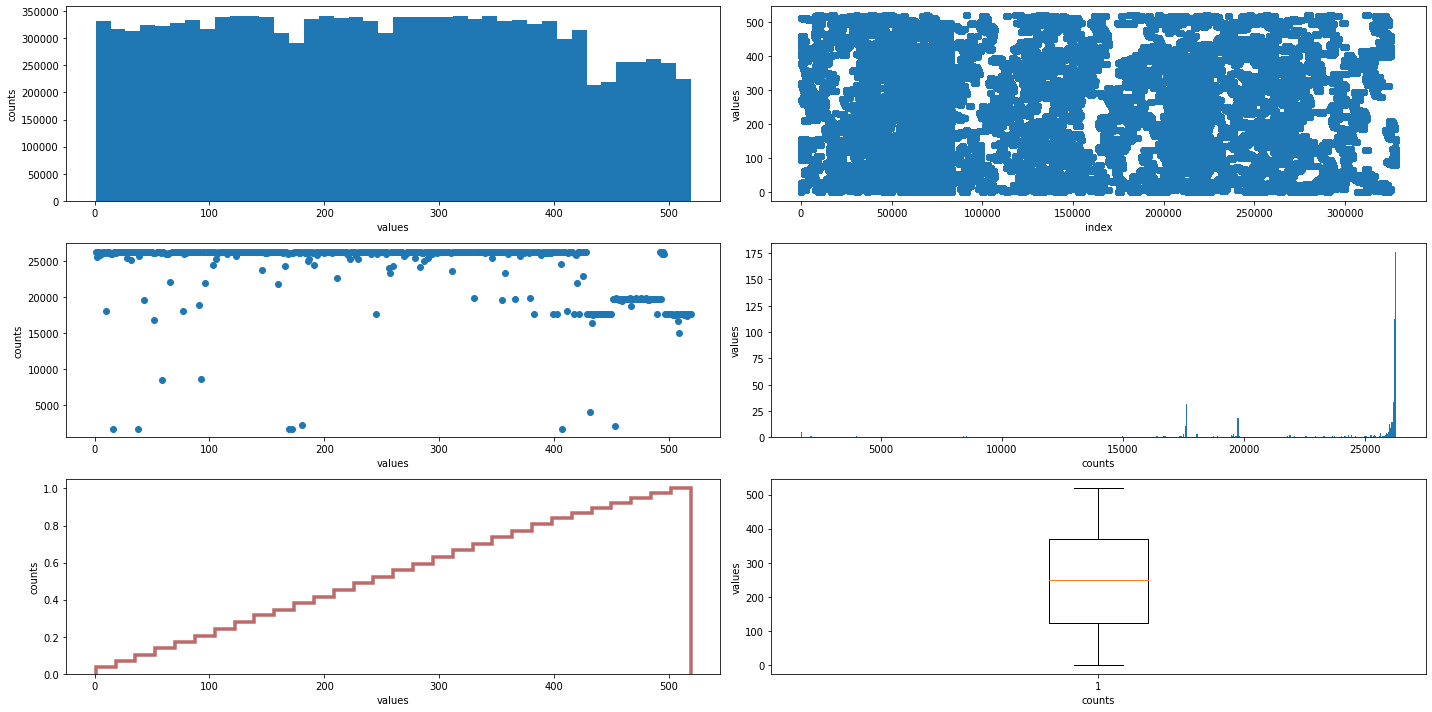

CPU times: user 17.7 s, sys: 1.96 s, total: 19.6 s
Wall time: 23.8 s


In [17]:
%%time

show_counts(data['all'].station_id.compute())

In [18]:
uniques['timestamp'].shape

(26033,)

value counts stats {'max': 26280, 'mean': 24145.275529865125, 'median': 26206.0, 'std': 4249.330443192494, 'min': 1703}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 8.72 s, sys: 240 ms, total: 8.96 s
Wall time: 42.5 s


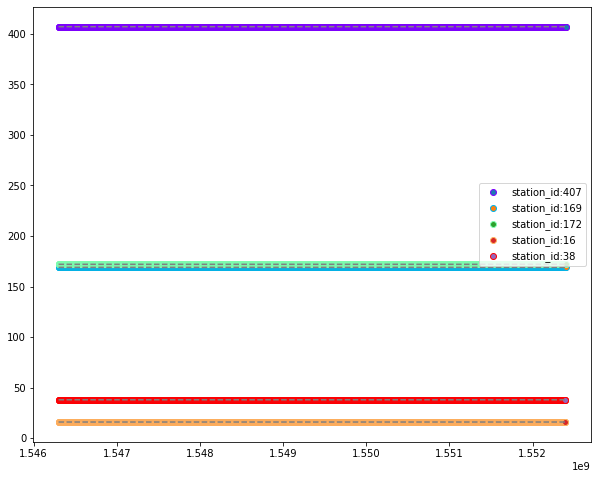

In [19]:
%%time

scatter_columns(
    data['all'], 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    #xticks=np.arange(uniques['timestamp'].min(),uniques['timestamp'].max(), 300),
    figsize=(10,8)
)

correct data 12527597 incorrect data 3801
CPU times: user 10.8 s, sys: 1.57 s, total: 12.3 s
Wall time: 47.1 s


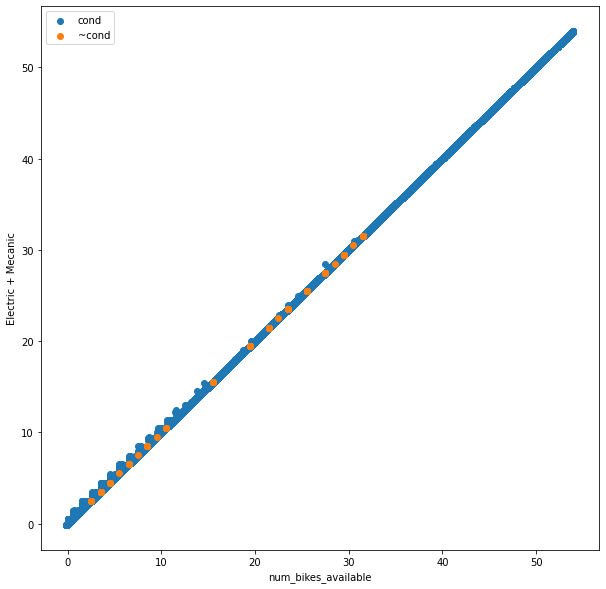

In [20]:
%%time

cond = data['all'].num_bikes_available.round().astype(int) == (data['all']['num_bikes_available_types.ebike'] + data['all']['num_bikes_available_types.mechanical']).round().astype(int)

print('correct data',data['all'][cond].shape[0].compute(), 'incorrect data', data['all'][~cond].shape[0].compute())
    
plt.rcParams["figure.figsize"] = (10,10)
    
plt.scatter(
    data['all'][cond].num_bikes_available.compute(), 
    (data['all'][cond]['num_bikes_available_types.ebike'] + data['all'][cond]['num_bikes_available_types.mechanical']).compute(),
    label='cond'
)

plt.scatter(
    data['all'][~cond].num_bikes_available.compute(), 
    (data['all'][~cond]['num_bikes_available_types.ebike'] + data['all'][~cond]['num_bikes_available_types.mechanical']).compute(),
    label='~cond'
)

plt.ylabel('Electric + Mecanic')
plt.xlabel('num_bikes_available')
plt.legend()

